In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vegas
from constants import *
#import multiprocessing as mp

In [2]:
#from geometry import getRprime,getd,getD,getCosPsi
#from crossSection import getVelocity,getMomentum,diffCrossSectionNuDM,totalCrossSectionDMe,dEv,getEv,maxPsi,maxtheta
from supernovaNuBoostedDM import *

In [7]:
def dnv(D,Ev,Lv = Lv,tau = 10):
    """
    Neutrino number density per energy at D
    
    Input
    ------
    Enu: Neutrino energy in MeV
    D: Distance from the boosted point to the SN explosion site, in kpc
    Lv: Neutrino luminosity, default is 1e52 erg/s
    tau: duration of the SN explosion
    
    Output
    ------
    Neutrino flux at d: # per Enu per cm**3
    """
    Lv = Lv*erg2MeV*tau
    D = D*kpc2cm
    
    # Fermi dirac distribution
    def _fv(Ev,Tv):
        exponent = Ev/Tv - 3
        if exponent <= 700:
            return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent) + 1))
        else:
            return 0
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    
    luminosity = Lv/(4*np.pi*D**2*lightSpeed)
    return luminosity*(nue_dist+nueb_dist+4*nux_dist)


def nx(r,mx):
    """
    DM halo number density at r in MW
    
    Input
    ------
    r: distance to GC, in kpc
    mx: DM mass in MeV
    
    Output
    ------
    DM number density, #/cm^3 at r
    """
    rr=r/24.42
    return (184/mx)/(rr*(1 + rr)**2)


def getJx(Tx,mx,mV,r,D,psi,gV=1,gD=1,tau=10):
    """
    Evaluate the BDM emissivity toward the direction psi at the given boosted point 
    
    Input
    ------
    Tx: BDM kinetic energy, MeV
    mx: DM mass, MeV
    mV: mediator mass, MeV
    r: distance from boosted point to GC for calculating DM number density, kpc
    D: distance from boosted point to the SN explosion site, kpc
    psi: the BDM scattering angle, rad
    gV: DM-neutrino coupling constant, default 1
    gD: DM-DM coupling constant, default 1
    
    Output
    ------
    jx: BDM emissivity at the boosted point, 1/(MeV*cm^3*s*rad)
    """   
    # Get the required Ev
    Ev = getEv(Tx,mx,psi)
    # Get dEv/dTx
    dEvdTx = dEv(Tx,mx,psi) 
    # Get the differential DM-nu scattering cross section
    diffCrox = diffCrossSectionNuDM(Tx,mx,mV,psi,gV,gD)
    # Get the emissivity jx
    jx = lightSpeed*diffCrox*nx(r,mx)*dnv(D,Ev,Lv,tau)*dEvdTx
    return jx


def diffFluxAtEarth(t,Tx,mx,mV,Rstar,theta,phi,beta,Re=8.5,r_cut=1e-5,gV=1,gD=1,tau=10):
    """
    The differential BDM flux over open angle theta at Earth
    
    Input
    ------
    t: The differential BDM flux at time t, relative to the first SN neutrino
        arriving at Earth
    Tx: BDM kinetic energy, MeV
    mx: DM mass, MeV
    mV: Mediator mass, MeV
    Rstar: Distance from Earth to SN, kpc
    theta: The open angle theta
    phi: The azimuthal angle along the Earth-SN axis, rad
    beta: The deviation angle, characterizing how SN deviates the GC, rad
    Re: The distance from Earth to GC, default 8.5 kpc
    r_cut: Ignore the BDM contribution when r' < r_cut, default 1e-5 kpc
    gV: DM-neutrino coupling constant, default 1
    gD: DM-DM coupling constant, default 1
    tau: The duration of SN explosion, default 10 s
    
    Output
    ------
    scalar: The diff. BDM flux at Earth, # per MeV per cm^2 per second per rad
    """
    # Get BDM velocity
    vx = getVelocity(Tx,mx)
    # Get the propagation length of BDM via given t and vx
    d = getd(t,vx,Rstar,theta)
    # Get the required SNv propagation length
    D = getD(d,Rstar,theta)
    # Get the distance between boosted point to GC
    rprime = getRprime(d,Re,theta,phi,beta)
    if  D != 0.0 and ~np.isnan(rprime) and rprime >= r_cut:
        # Get the BDM scattering angle psi
        psi = np.arccos(getCosPsi(d,Rstar,theta))
        # Evaluate the xemissivity
        jx = getJx(Tx,mx,mV,rprime,D,psi,gV,gD,tau)
        # Jacobian
        J = lightSpeed/((d - Rstar*np.cos(theta))/D + 1/vx)
        # BDM flux
        return J*jx*vx*np.sin(theta)
    else:
        return 0



In [84]:
get_tvan_thetaM(100,1e-3,17)

(4374397.346931229, 0.0022360418903693505)

In [83]:
get_tvan_thetaM(100,1e-3,8.5)

(2187198.6734656147, 0.0022360418903693505)

In [91]:
Rstar1 = 8.5
Rstar2 = 17
Rstar3 = 17
Tx = 15
mx = 1e-3
mV = mx/3
theta_ls = np.logspace(-5,np.log10(np.pi/2),50)
phi_ls = np.linspace(0,2*np.pi,20)
bdmflux1 = []
bdmflux2 = []
bdmflux3 = []
beta1 = 0
beta2 = 0
beta3 = 0.5*np.pi
tvan1,thetaM1 = get_tvan_thetaM(Tx,mx,Rstar1)
tvan2,thetaM2 = get_tvan_thetaM(Tx,mx,Rstar2)
tvan3,thetaM3 = get_tvan_thetaM(Tx,mx,Rstar3)
time_ls1 = np.linspace(1,tvan1,50)
time_ls2 = np.linspace(1,tvan2,50)
integ1 = vegas.Integrator([[0, thetaM1],[0,2*np.pi]])
integ2 = vegas.Integrator([[0, thetaM2],[0,2*np.pi]])
integ3 = vegas.Integrator([[0, thetaM3],[0,2*np.pi]])


i = 1
for t in time_ls1:
    # Target function
    def f1(x):
        theta = x[0]
        phi = x[1]
        return diffFluxAtEarth(t,Tx,mx,mV,Rstar1,theta=theta,phi=phi,beta=beta1)
    # Setup integrand for vegas
    result1 = integ2(f1,nitn=10,neval=2000)
    bdmflux1.append(result1.mean)
bdmflux1 = np.array(bdmflux1)

for t in time_ls2:
    def f2(x):
        theta = x[0]
        phi = x[1]
        return diffFluxAtEarth(t,Tx,mx,mV,Rstar2,theta=theta,phi=phi,beta=beta2)
    
    def f3(x):
        theta = x[0]
        phi = x[1]
        return diffFluxAtEarth(t,Tx,mx,mV,Rstar3,theta=theta,phi=phi,beta=beta3)
    
    # Setup integrand for vegas
    result2 = integ2(f2,nitn=10,neval=2000)
    bdmflux2.append(result2.mean)
    result3 = integ3(f3,nitn=10,neval=2000)
    bdmflux3.append(result3.mean)
    print(i,end='\r')
    i+=1
bdmflux2 = np.array(bdmflux2)
bdmflux3 = np.array(bdmflux3)

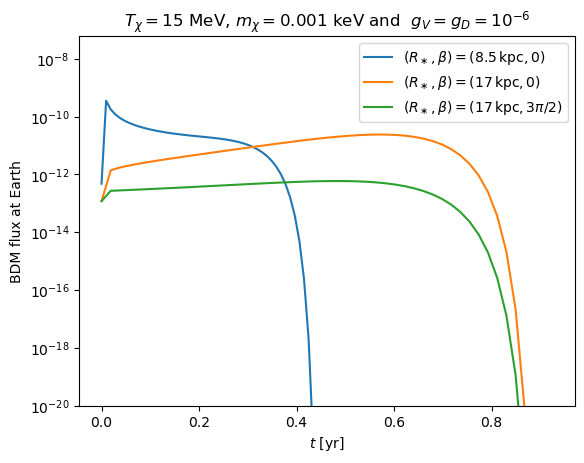

In [93]:
plt.plot(time_ls1/yr2s,np.array(bdmflux1)*1e-24,label=r'$(R_\ast,\beta)=(8.5\,{\rm kpc},0)$')
plt.plot(time_ls2/yr2s,bdmflux2*1e-24,label=r'$(R_\ast,\beta)=(17\,{\rm kpc},0)$')
plt.plot(time_ls2/yr2s,bdmflux3*1e-24,label=r'$(R_\ast,\beta)=(17\,{\rm kpc},3\pi/2)$')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$ [yr]')
plt.ylabel(r'BDM flux at Earth')
plt.title(f'$T_\chi = {Tx}$ MeV, $m_\chi = {mx}$ keV and ' + ' $g_V=g_D=10^{-6}$')
plt.legend()
plt.ylim(1e-20)
plt.savefig('flux_4.pdf',bbox_inches='tight')

In [89]:
#theta_ls = np.logspace(-5,np.log10(np.pi/2),50)
#phi_ls = np.linspace(0,2*np.pi,20)
gV = 1e-6
gD = 1e-6
event_Rstar1 = []
event_Rstar2 = []
mx_ls = np.logspace(-6,1.5,20)
Rstar1= 8.5
Rstar2= 17
i = 1
for mx in mx_ls:
    mV = mx/3
    # Target function
    def f1(x):
        t = x[0]
        Tx = x[1]
        theta = x[2]
        phi = x[3]
        return diffFluxAtEarth(t,Tx,mx,mV,Rstar1,theta=theta,phi=phi,beta=0,gV=gV,gD=gD)
    
    def f2(x):
        t = x[0]
        Tx = x[1]
        theta = x[2]
        phi = x[3]
        return diffFluxAtEarth(t,Tx,mx,mV,Rstar2,theta=theta,phi=phi,beta=0.5*np.pi,gV=gV,gD=gD)
    # Setup integrand for vegas
    tvan1,thetaM1 = get_tvan_thetaM(5,mx,Rstar1)
    tvan2,thetaM2 = get_tvan_thetaM(5,mx,Rstar2)
    if tvan1 > 35*yr2s: tvan1 = 35*yr2s
    else: pass
    if tvan2 > 35*yr2s: tvan2 = 35*yr2s
    else: pass
    integ1 = vegas.Integrator([[1,tvan1],[5,100],[0, thetaM1],[0,2*np.pi]])
    integ2 = vegas.Integrator([[1,tvan2],[5,100],[0, thetaM2],[0,2*np.pi]])
    result1 = integ1(f1,nitn=10,neval=10000)
    event_Rstar1.append(result1.mean)
    result2 = integ2(f2,nitn=10,neval=10000)
    event_Rstar2.append(result2.mean)
    
    print(i,end='\r')
    i+=1

Text(0, 0.5, '$\\int \\frac{d\\Phi_\\chi}{dT_\\chi dt} dT_\\chi dt$')

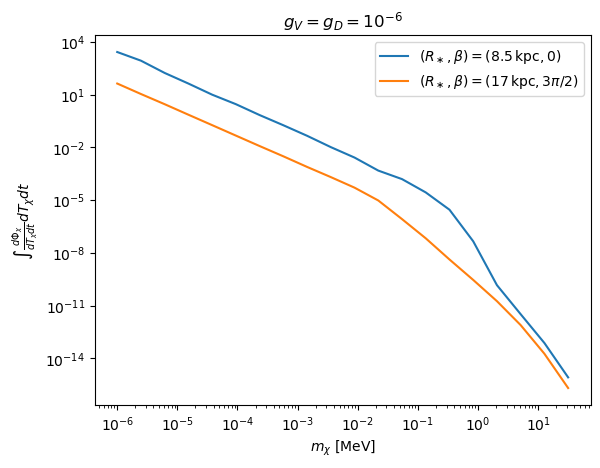

In [90]:
plt.plot(mx_ls,np.array(event_Rstar1),label=r'$(R_\ast,\beta)=(8.5\,{\rm kpc},0)$')
#plt.plot(mx_ls,event_theta001,label=r'$\beta=0.001$')
plt.plot(mx_ls,event_Rstar2,label=r'$(R_\ast,\beta)=(17\,{\rm kpc},3\pi/2)$')
#plt.plot(mx_ls,event_t_bound,'.',label=r'$t_{\rm interval}=[5\,{\rm s},35\,{\rm yrs}]$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$g_V=g_D=10^{-6}$')
plt.legend()
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$\int \frac{d\Phi_\chi}{dT_\chi dt} dT_\chi dt$')
#plt.savefig('event.pdf',bbox_inches='tight')
#plt.ylim(1e-4,1e1)

In [76]:
event_Rstar1[8]/event_Rstar2[8]

63.453884970578734

In [118]:
Tx= 15
mx_ls = np.logspace(-6,1,30)
crox_ls_lightMv = []
crox_ls_heavyMv = []
for mx in mx_ls:
    result = quad(lambda psi: diffCrossSectionNuDM(Tx,mx,mx/10,psi,1,1),0,maxPsi(Tx,mx))
    result2 = quad(lambda psi: diffCrossSectionNuDM(Tx,mx,10*mx,psi,1,1),0,maxPsi(Tx,mx))
    crox_ls_lightMv.append(result[0])
    crox_ls_heavyMv.append(result2[0])
#crox_ls = np.array(crox_ls)

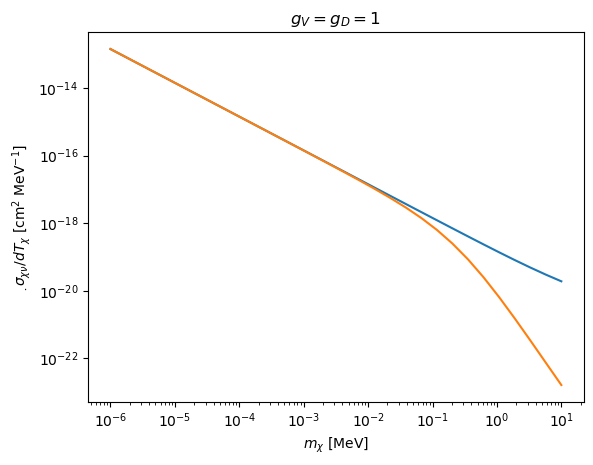

In [123]:
plt.plot(mx_ls,crox_ls_lightMv,label=r'$m_V=m_\chi/10$')
plt.plot(mx_ls,crox_ls_heavyMv,label=r'$m_V=10m_\chi$')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-30,)
plt.title(r'$g_V=g_D=1$')
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$\d\sigma_{\chi\nu}/dT_\chi$ [cm$^2$ MeV$^{-1}$]')
plt.savefig('sig.pdf',bbox_inches='tight')

In [62]:
crox_ls

array([2.13287307e-14, 2.13287296e-15, 2.13287322e-16, 2.13288389e-17,
       2.13299106e-18, 2.13406206e-19, 2.14469272e-20, 2.24376358e-21])

In [43]:
ph_ls = np.logspace(-9,np.log10(np.pi/2),100)
Ev_ls = np.linspace(5,100,50)

In [44]:
two_dim = []
ev_1000 = []
ev_100 = []
ev_50 = []
ev_5 = []
for phi in ph_ls:
    #sigxv = diffCrossSectionNuDM(np.cos(phi),Ev,1e-3,1e-3/3,1,1)
    ev_100.append(diffCrossSectionNuDM(np.cos(phi),100,1e-3,1e-3/3,1,1))
    ev_50.append(diffCrossSectionNuDM(np.cos(phi),50,1e-3,1e-3/3,1,1))
    ev_5.append(diffCrossSectionNuDM(np.cos(phi),5,1e-3,1e-3/3,1,1))
    ev_1000.append(diffCrossSectionNuDM(np.cos(phi),1000,1e-3,1e-3/3,1,1))
    

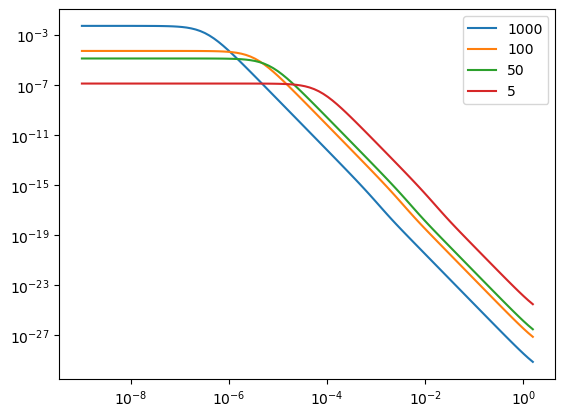

In [45]:
plt.plot(ph_ls,ev_1000,label=1000)
plt.plot(ph_ls,ev_100,label=100)
plt.plot(ph_ls,ev_50,label=50)
plt.plot(ph_ls,ev_5,label=5)
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [31]:
Tx = 5
mx = 1e-3
Rstar = 8.5
vx = get_BDMv(Tx,mx)
theta_ls = np.logspace(-9,np.log10(np.pi),100)
t = 1000*yr2s
diffsigxv = []
Ev_ls = []
d_ls = []
D_ls = []
psi_ls =[]
phi_ls =[]
for theta in theta_ls:
    d = get_d(t,vx,Rstar,theta)
    cospsi = get_cosPsi(d,Rstar,theta)
    Ev,cosphi,flag,_ = get_Ev_cosPhi(Tx,mx,cospsi,max_Ev = 100)
    D = get_D(d,Rstar,theta)
    if flag == 'valid':
        sigxv = diffCrossSectionNuDM(cosphi,Ev,mx,mx/3,1,1)*dnv(D,Ev)
    else:
        sigxv = 0
        Ev = 0
    diffsigxv.append(sigxv)
    Ev_ls.append(Ev)
    d_ls.append(d)
    D_ls.append(D)
    psi_ls.append(cospsi)
    phi_ls.append(cosphi)

Text(0.5, 0, '$\\theta$ [$\\pi$]')

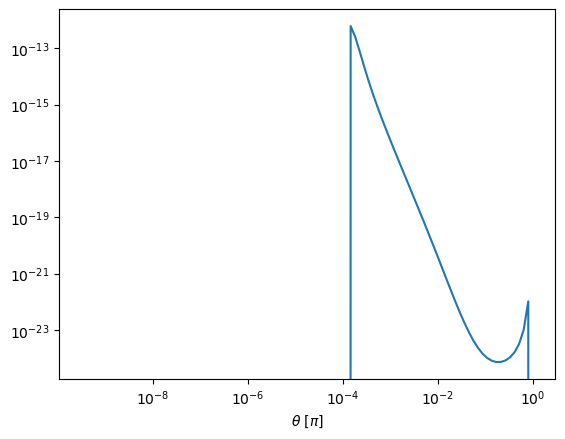

In [13]:
plt.plot(theta_ls/np.pi,diffsigxv)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [$\pi$]')
#plt.xlim(1e-4,)

Text(0.5, 0, '$\\theta$ [$\\pi$]')

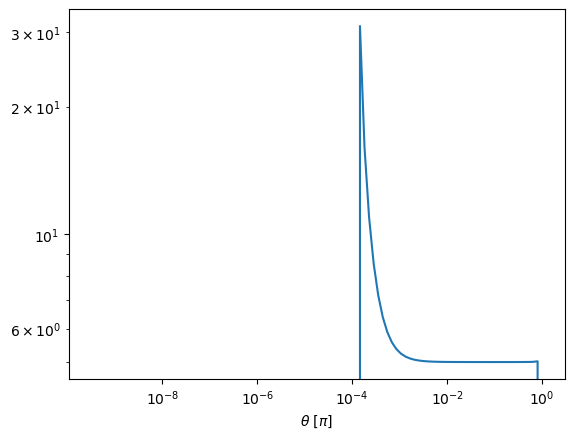

In [14]:
plt.plot(theta_ls/np.pi,Ev_ls)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [$\pi$]')

Text(0.5, 0, '$\\theta$ [$\\pi$]')

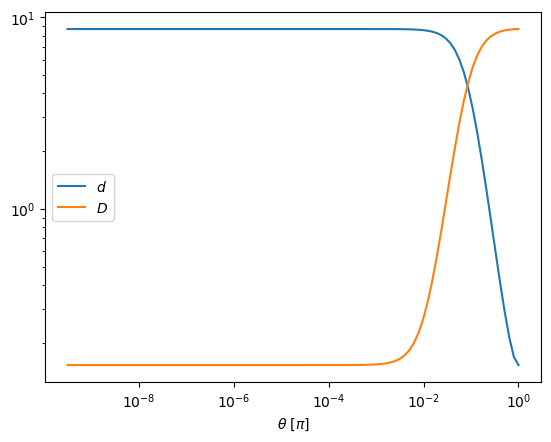

In [15]:
plt.plot(theta_ls/np.pi,d_ls,label='$d$')
plt.plot(theta_ls/np.pi,D_ls,label='$D$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [$\pi$]')

Text(0.5, 0, '$cos\\phi$')

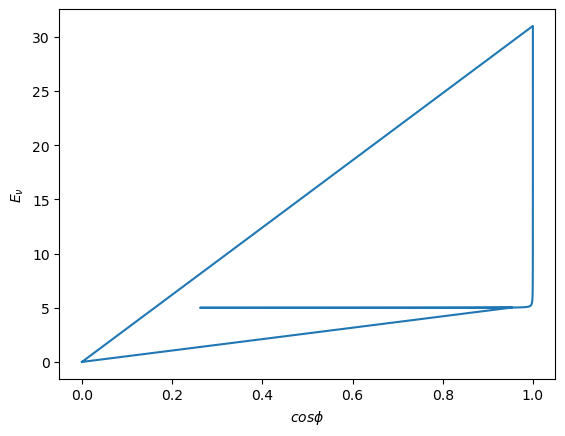

In [39]:
plt.plot(np.nan_to_num(phi_ls),Ev_ls)
#plt.plot(theta_ls/np.pi,np.arccos(phi_ls)/np.pi,label='$\phi$')
#plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'$E_\nu$')
plt.xlabel(r'$cos\phi$')

In [38]:
d_theta=[]
D_theta=[]
rprime_theta=[]

Tx = 10
mx = 1e-6
Rstar = 5
Re = 8.5
phi = 0.3
beta=1.1
vx = getVelocity(Tx,mx)
t_ls = np.linspace(0,1,100)
theta_ls = np.linspace(0,get_tvan_thetaM(Tx,mx,Rstar)[1],10)
for theta in theta_ls:
    d_t=[]
    D_t=[]
    rprime_t=[]
    for t in t_ls:
        d=getd(t,vx,Rstar,theta)
        D=getD(d,Rstar,theta)
        rprime=getRprime(d,Rstar,Re,theta,phi,beta)
        d_t.append(d)
        D_t.append(D)
        rprime_t.append(rprime)
    d_theta.append(d_t)
    D_theta.append(D_t)
    rprime_theta.append(rprime_t)
d_theta = np.array(d_theta)
D_theta = np.array(D_theta)
rprime_theta = np.array(rprime_theta)

In [40]:
d_theta

array([[0.00000000e+00, 5.00764929e+00, 4.99805459e+00, 5.00536800e+00,
        5.00151061e+00, 5.00119333e+00, 4.99940922e+00, 4.99949648e+00,
        5.00073036e+00, 5.00064717e+00, 5.00150918e+00, 5.00136929e+00,
        5.00048160e+00, 5.00044397e+00, 5.00106996e+00, 4.99976976e+00,
        5.00035925e+00, 5.00033788e+00, 4.99980875e+00, 5.00078474e+00,
        5.00028647e+00, 5.00027272e+00, 4.99984393e+00, 5.00064670e+00,
        5.00023821e+00, 5.00022862e+00, 4.99986818e+00, 5.00054996e+00,
        5.00020387e+00, 5.00019680e+00, 5.00049441e+00, 4.99988960e+00,
        5.00017818e+00, 5.00017276e+00, 4.99989943e+00, 4.99990231e+00,
        5.00015824e+00, 5.00015395e+00, 4.99991009e+00, 4.99991240e+00,
        5.00014231e+00, 5.00013883e+00, 4.99991870e+00, 4.99992060e+00,
        5.00012930e+00, 5.00012642e+00, 5.00032148e+00, 4.99992739e+00,
        5.00011847e+00, 5.00011605e+00, 4.99993178e+00, 4.99993312e+00,
        5.00010931e+00, 5.00010725e+00, 4.99993686e+00, 5.000268

In [16]:
get_tvan_thetaM?

Signature: get_tvan_thetaM(Tx, mx, Rstar)
Docstring:
Get the vanishing time and maximum theta

Input
------
Tx: BDM kinetic energy
mx: Mass of DM
Rstar: Distance from SN to the Earth, kpc

Output
------
tup: maximum theta, rad
File:      ~/GitHub/SNnuBDM2/src/supernovaNuBoostedDM.py
Type:      function


In [20]:
np.arccos(-1)

3.141592653589793

In [17]:
np.isnan(phi_ls[2])

True

In [21]:
True and False

False